In [2]:
#import libraries
import json, zstandard as zstd, pandas as pd, numpy as np, requests, io, os, re
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [3]:
#import dataset
zst_path = "./glbx-mdp3-20201009-20251008.ohlcv-1d.csv.zst"

with open(zst_path, "rb") as fh:
    dctx = zstd.ZstdDecompressor()
    with dctx.stream_reader(fh) as reader:
        df = pd.read_csv(reader, encoding="utf-8", parse_dates=["ts_event"])

df.head(50)

,ts_event,rtype,publisher_id,instrument_id,open,high,low,close,volume,symbol
0,2020-10-09 00:00:00+00:00,35,1,178892,-0.0097,-0.0093,-0.0101,-0.0096,439,HOJ1-HOK1
1,2020-10-09 00:00:00+00:00,35,1,112388,-0.0800,-0.0700,-0.0800,-0.0700,10,CLG2-CLJ2
2,2020-10-09 00:00:00+00:00,35,1,93394,-0.0800,-0.0600,-0.1100,-0.0800,961,CLZ1-CLH2
3,2020-10-09 00:00:00+00:00,35,1,4135,-3.8600,-3.8600,-3.8600,-3.8600,1,CLZ0-BZM1
4,2020-10-09 00:00:00+00:00,35,1,180969,-0.0135,-0.0132,-0.0151,-0.0135,577,RBJ1-RBK1
5,2020-10-09 00:00:00+00:00,35,1,26650,-0.1300,-0.1300,-0.1500,-0.1500,1476,CLM1-CLN1
6,2020-10-09 00:00:00+00:00,35,1,289790,-0.0136,-0.0122,-0.0137,-0.0125,7529,HOZ0-HOF1
7,2020-10-09 00:00:00+00:00,35,1,245031,-0.0026,-0.0016,-0.0026,-0.0021,76,HO:BF F1-G1-H1
8,2020-10-09 00:00:00+00:00,35,1,152252,-0.0044,-0.0038,-0.0044,-0.0039,59,HO:BF G1-H1-J1
9,2020-10-09 00:00:00+00:00,35,1,100895,-0.3300,-0.3100,-0.3900,-0.3300,1044,CLM2-CLZ2


In [4]:
#cleaning
df = df.drop(columns=['publisher_id', 'rtype'])
df['ts_event'] = df['ts_event'].dt.date          
df = df.rename(columns={'ts_event': 'date'})
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'].dt.to_period('M') != '2025-04'] #remove liberation day data
print(len(df))
df.head()

531311


,date,instrument_id,open,high,low,close,volume,symbol
0,2020-10-09,178892,-0.0097,-0.0093,-0.0101,-0.0096,439,HOJ1-HOK1
1,2020-10-09,112388,-0.0800,-0.0700,-0.0800,-0.0700,10,CLG2-CLJ2
2,2020-10-09,93394,-0.0800,-0.0600,-0.1100,-0.0800,961,CLZ1-CLH2
3,2020-10-09,4135,-3.8600,-3.8600,-3.8600,-3.8600,1,CLZ0-BZM1
4,2020-10-09,180969,-0.0135,-0.0132,-0.0151,-0.0135,577,RBJ1-RBK1


In [5]:
#displaying available products
products = sorted(set(
    re.match(r'^([A-Z]{2})', s).group(1)
    for s in df['symbol'].dropna().unique()
    if re.match(r'^([A-Z]{2})', s)
))

products

['CL', 'CS', 'HO', 'RB', 'UD']

In [6]:
#CME Month Codes
month_map = {
    "F": 1, "G": 2, "H": 3, "J": 4, "K": 5, "M": 6,
    "N": 7, "Q": 8, "U": 9, "V": 10, "X": 11, "Z": 12
}

def parse_expiry(symbol: str) -> pd.Timestamp | None:
    m = re.match(r'([A-Z]{2})([FGHJKMNQUVXZ])(\d)', symbol)
    if not m:
        return None
    _, month_code, year_digit = m.groups()
    year = 2020 + int(year_digit)
    month = month_map[month_code]
    return pd.Timestamp(year, month, 1)

def filter_symbol(df: pd.DataFrame, prefix: str) -> pd.DataFrame:
    pattern = rf'^{re.escape(prefix)}[A-Z]\d-{re.escape(prefix)}[A-Z]\d$'
    filtered = df[df['symbol'].str.match(pattern, na=False)].copy()
    filtered = filtered[filtered['volume'] > 100]  # filter low volume
    filtered.reset_index(drop=True, inplace=True)
    return filtered

def classify_spread(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df[['front_leg','back_leg']] = df['symbol'].str.split('-', expand=True)
    df['front_exp'] = df['front_leg'].apply(parse_expiry)
    df['back_exp'] = df['back_leg'].apply(parse_expiry)
    spread_labels = []

    for trade_date, group in df.groupby('date'):
        expiries = sorted(group['front_exp'].unique())
        exp_rank = {exp: i for i, exp in enumerate(expiries)}
        for _, row in group.iterrows():
            i = exp_rank.get(row['front_exp'])
            j = exp_rank.get(row['back_exp'])
            label = f"M{i}-M{j}" if i is not None and j is not None else None
            spread_labels.append(label)
    df['spread_label'] = spread_labels
    return df

def process_symbol(df: pd.DataFrame, prefix: str) -> dict:
    filtered = filter_symbol(df, prefix)
    labeled = classify_spread(filtered)
    return {label: grp.copy() for label, grp in labeled.groupby('spread_label')}

def plot_spread(spread_df, title=None):
    if spread_df.empty:
        print("⚠️ No data to plot.")
        return
    
    plt.figure(figsize=(10, 5))
    plt.plot(spread_df['date'], spread_df['close'], marker='.', linewidth=1.5)
    plt.title(title or spread_df['spread_label'].iloc[0])
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [7]:
spreads = process_symbol(df, 'CL')

M0_M1 = spreads['M0-M1']
M1_M2 = spreads['M1-M2']
M2_M3 = spreads['M2-M3']

M0_M1.head(50)

,date,instrument_id,open,high,low,close,volume,symbol,front_leg,back_leg,front_exp,back_exp,spread_label
30,2020-10-09,194527,-0.28,-0.27,-0.31,-0.30,65372,CLX0-CLZ0,CLX0,CLZ0,2020-11-01,2020-12-01,M0-M1
72,2020-10-11,194527,-0.31,-0.30,-0.31,-0.31,625,CLX0-CLZ0,CLX0,CLZ0,2020-11-01,2020-12-01,M0-M1
99,2020-10-12,194527,-0.31,-0.28,-0.32,-0.29,59945,CLX0-CLZ0,CLX0,CLZ0,2020-11-01,2020-12-01,M0-M1
204,2020-10-13,194527,-0.30,-0.25,-0.30,-0.28,106376,CLX0-CLZ0,CLX0,CLZ0,2020-11-01,2020-12-01,M0-M1
277,2020-10-14,194527,-0.28,-0.26,-0.30,-0.28,98754,CLX0-CLZ0,CLX0,CLZ0,2020-11-01,2020-12-01,M0-M1
292,2020-10-15,194527,-0.27,-0.26,-0.30,-0.27,42646,CLX0-CLZ0,CLX0,CLZ0,2020-11-01,2020-12-01,M0-M1
349,2020-10-16,194527,-0.27,-0.23,-0.27,-0.23,36651,CLX0-CLZ0,CLX0,CLZ0,2020-11-01,2020-12-01,M0-M1
401,2020-10-18,194527,-0.24,-0.23,-0.25,-0.24,631,CLX0-CLZ0,CLX0,CLZ0,2020-11-01,2020-12-01,M0-M1
453,2020-10-19,194527,-0.25,-0.21,-0.25,-0.22,39543,CLX0-CLZ0,CLX0,CLZ0,2020-11-01,2020-12-01,M0-M1
500,2020-10-20,194527,-0.22,-0.18,-0.24,-0.20,14318,CLX0-CLZ0,CLX0,CLZ0,2020-11-01,2020-12-01,M0-M1


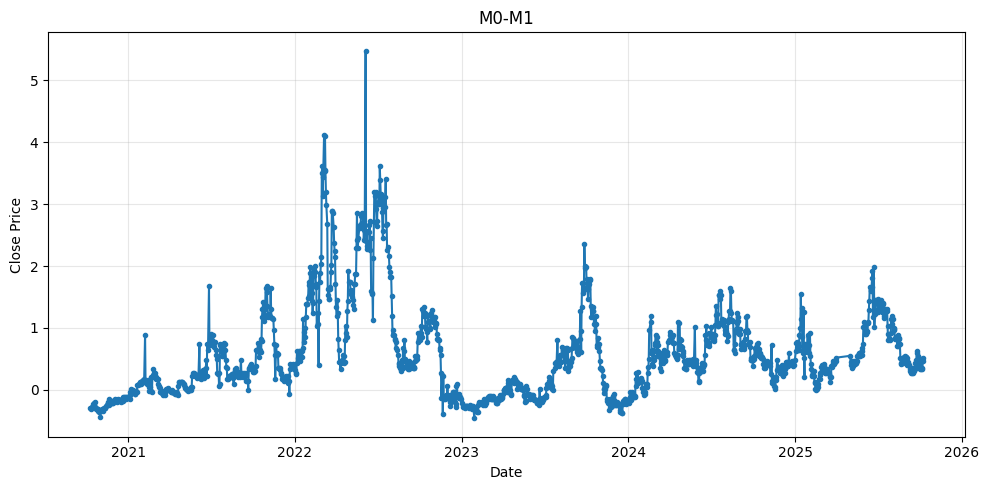

In [8]:
plot_spread(M0_M1)